In [ ]:
# default_exp game

# game

> Generate boards to play games of truth and conseqeunces.

In [ ]:
# hide
from nbdev.showdoc import *

%load_ext nb_black
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"

from truthiness.plot import plot_maze
from truthiness.plot import plot_boards
from truthiness.plot import plot_histograms
from truthiness.plot import plot_available

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [ ]:
# export
import numpy as np

<IPython.core.display.Javascript object>

## overview
In this module we define code for all the parts needed to make a playable information and conseqeunces game. This includes values for information $E$ and consequences $Q$, finding available moves, and generating the maze a player will need to traverse. 

**The code for the playable games themselves are found in the `gym` module.**

## mazes
Mazes are made by a diffusion process. We do not promise in creating a maze that every position can be reached from any other. The seperate `check_maze()` function can help with that, with the caveat that it can be slow to run.

In [ ]:
# export
def create_maze(n, k=4, t=4, prng=None):
    """Create a maze, by diffusing out from k points.

    Params
    ------
    n : int
        Board size
    k : int
        The number of starting points
    t : int
        The number of time steps for diffusion
    prng : None, np.random.RandonState
        Controls seeding
    """
    if prng is None:
        prng = np.random.RandomState()

    maze = np.zeros((n, n))

    # Initial seends
    locs = []
    for _ in range(k):
        x0, y0 = prng.randint(0, n, 2)
        locs.append((x0, y0))

    # Moving t steps from x0,y0
    # fill in neighbors
    # by random draw
    for x0, y0 in locs:
        x, y = x0, y0
        maze[x, y] = 1
        for step in range(t):
            # Draw
            dx = prng.randint(-1, 2)
            if np.isclose(dx, 0):
                dy = prng.randint(-1, 2)
            else:
                dy = 0

            # Sane and safe moves?
            if x + dx < 0:
                dx = 0
            if x + dx >= n:
                dx = 0
            if y + dy < 0:
                dy = 0
            if y + dy >= n:
                dy = 0

            # Add to maze
            x += dx
            y += dy
            maze[x, y] = 1

    return maze

<IPython.core.display.Javascript object>

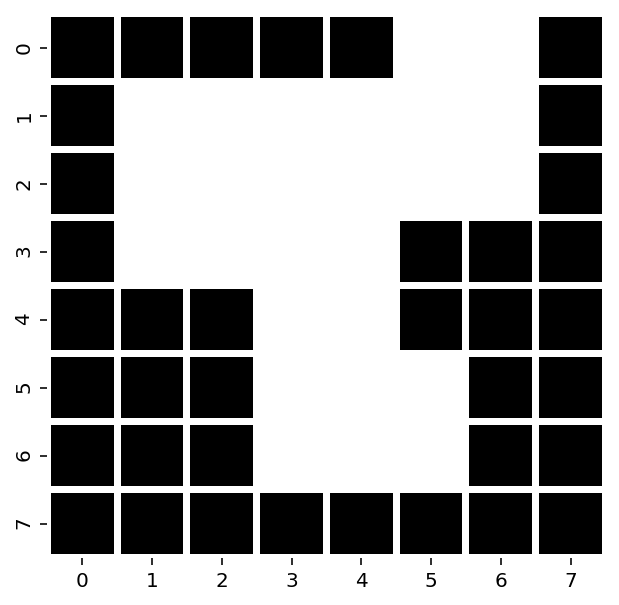

<IPython.core.display.Javascript object>

In [ ]:
maze = create_maze(8, k=5, t=10)
plot_maze(maze, plot=True, height=5, width=5)

In [ ]:
def check_maze(n, maze):
    # TODO - Try every starting place to get to the opposite corder
    pass

<IPython.core.display.Javascript object>

## different games with different relations between truth and consequences.

In the 'shame game', truth and conseqeunces are each others opposite, and so the more one learns the more one is ashamed of having not known it to begin with. The amount of shame is scaled by `shame`.

Unless noted otherwise samples of value and consequeneces are drawn from a lognormal distribtuion, whose variance is set by `sigma`.

In [ ]:
# export
def shame_game(n=8, sigma=0.5, shame=1, maze=None, prng=None):
    if prng is None:
        prng = np.random.RandomState()

    if maze is None:
        maze = 1  # do nothing
    else:
        maze = np.logical_not(maze)  # mask w/ maze

    E = np.random.lognormal(sigma=sigma, size=n ** 2)
    E /= np.max(E)
    Q = shame * E

    E = E.reshape(n, n)
    Q = Q.reshape(n, n)

    return E * maze, Q * maze

<IPython.core.display.Javascript object>

In [ ]:
# export
def plot_boards(
    E, Q, plot=False, path=None, height=2, width=3, name="board.png", **heatmap_kwargs
):
    """Plot the boards"""

    # Fix colors (overide kwargs)
    cmap = sns.diverging_palette(300, 145, s=60, as_cmap=True)

    # Plot!
    fig, ax = plt.subplots(ncols=2, figsize=(width, height))  # Sample figsize in inches
    ax[0] = sns.heatmap(
        E, linewidths=3, center=0, ax=ax[0], cmap=cmap, cbar=False, **heatmap_kwargs
    )
    ax[1] = sns.heatmap(
        -Q, linewidths=3, center=0, ax=ax[1], cmap=cmap, cbar=False, **heatmap_kwargs
    )

    ax[0].title.set_text("$E$")
    ax[1].title.set_text("$Q$")

    # Save an image?
    if path is not None:
        plt.savefig(os.path.join(path, name))

    # Show?
    if plot:
        plt.pause(0.01)
    plt.close("all")

<IPython.core.display.Javascript object>

- Example of a `shame_game`:

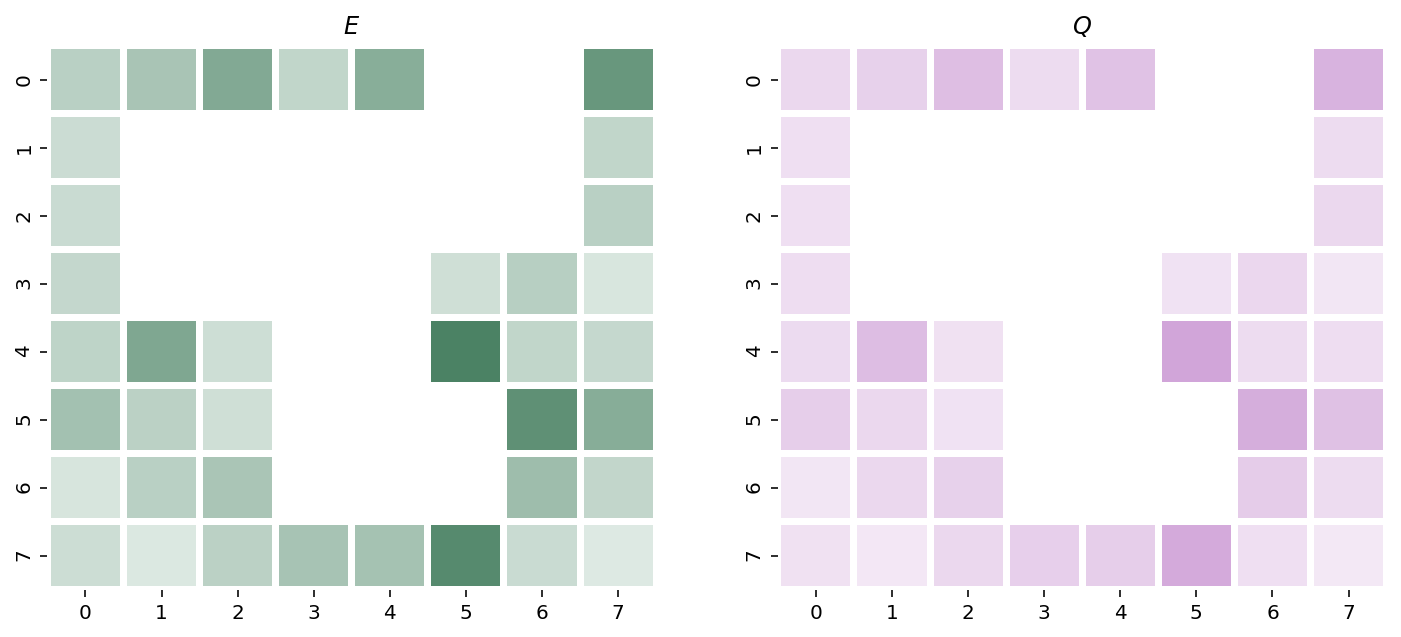

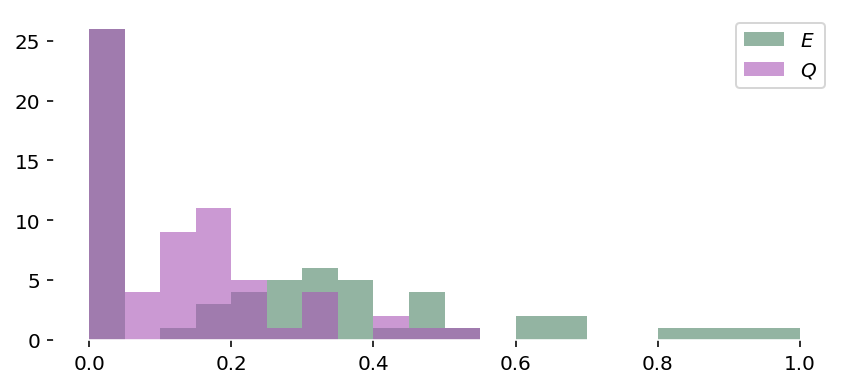

<IPython.core.display.Javascript object>

In [ ]:
E, Q = shame_game(8, shame=0.5, maze=maze)
plot_boards(E, Q, height=5, width=12, plot=True, vmin=-1, vmax=1, mask=maze)
plot_histograms(E, Q, height=3, width=7, plot=True, range=(0, 1), bins=20, alpha=0.6)

In the 'plain game' truth and conseqeunces are independent, but sampled so there are a few rare extreme events.

In [ ]:
# export
def plain_game(n=10, sigma=0.5, maze=None, prng=None):
    if prng is None:
        prng = np.random.RandomState()

    if maze is None:
        maze = 1  # do nothing
    else:
        maze = np.logical_not(maze)  # mask w/ maze

    E = np.random.lognormal(sigma=sigma, size=n ** 2)
    E /= np.max(E)
    E = E.reshape(n, n)
    Q = np.random.lognormal(sigma=sigma, size=n ** 2)
    Q /= np.max(Q)
    Q = Q.reshape(n, n)

    return E * maze, Q * maze

<IPython.core.display.Javascript object>

- Example of a `plain_game`

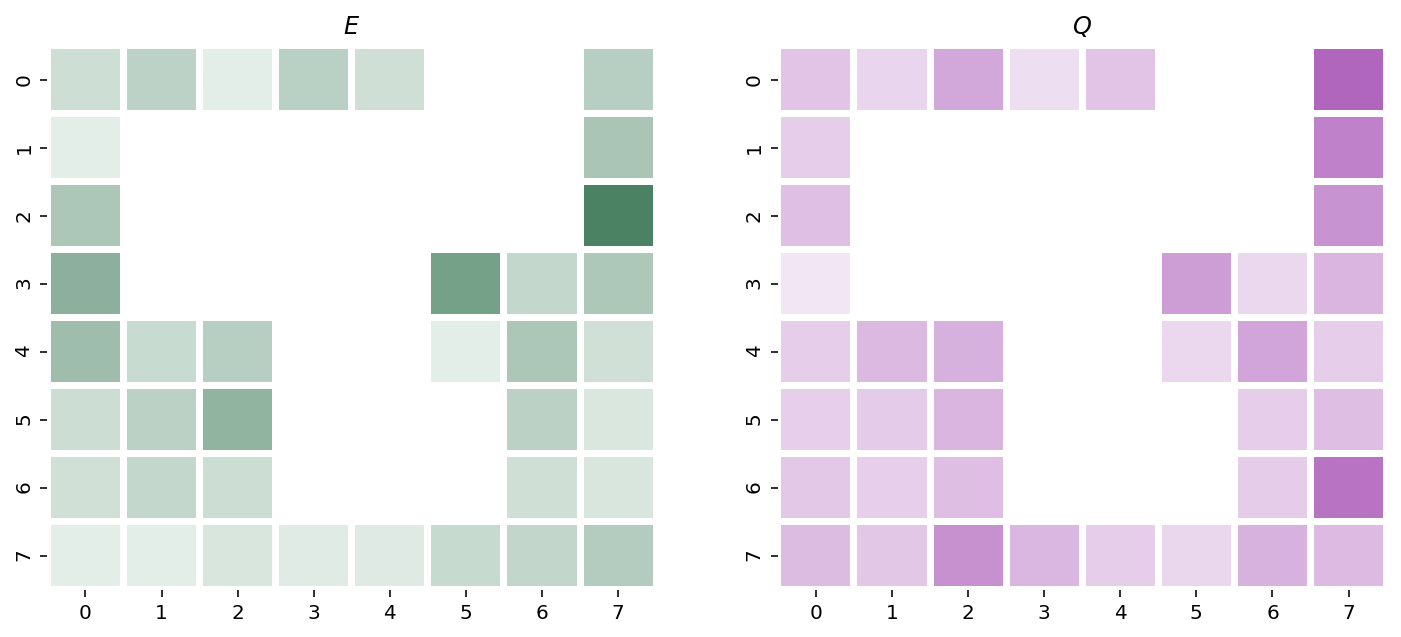

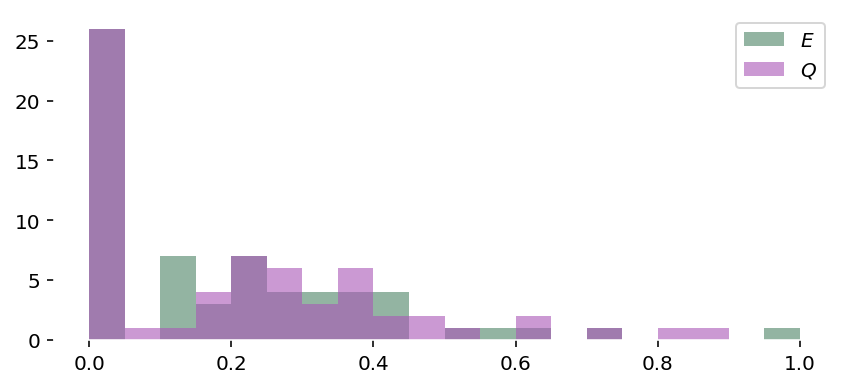

<IPython.core.display.Javascript object>

In [ ]:
E, Q = plain_game(8, maze=maze)
plot_boards(E, Q, height=5, width=12, plot=True, vmin=-1, vmax=1, mask=maze)
plot_histograms(E, Q, height=3, width=7, plot=True, range=(0, 1), bins=20, alpha=0.6)

## how to be making moves
Define functions to find valid intial starting location, and moves from that place.

In [ ]:
# export
def random_move(maze):
    """Choose a valid starting location, (x, y)"""

    valid = np.argwhere(np.logical_not(maze)).tolist()
    np.random.shuffle(valid)

    return tuple(valid[0])

<IPython.core.display.Javascript object>

In [ ]:
# export
def available_moves(x, y, maze):
    """Given an (x, y) position, generate available moves"""
    N = maze.shape[0]
    available = []

    # Go down
    for n in range(x + 1, N):
        if maze[n, y] == 0:
            available.append((n, y))
        else:
            break

    # Go up
    for n in reversed(range(0, x)):
        if maze[n, y] == 0:
            available.append((n, y))
        else:
            break

    # Go left
    for n in range(y + 1, N):
        if maze[x, n] == 0:
            available.append((x, n))
        else:
            break

    # Go right
    for n in reversed(range(0, y)):
        if maze[x, n] == 0:
            available.append((x, n))
        else:
            break

    return available

<IPython.core.display.Javascript object>

- Example of creating a maze, picking a random place to start in that maze, and discovering the available moves from that point.
- The yellow box is the starting place
- Red boxes are the available moves from there

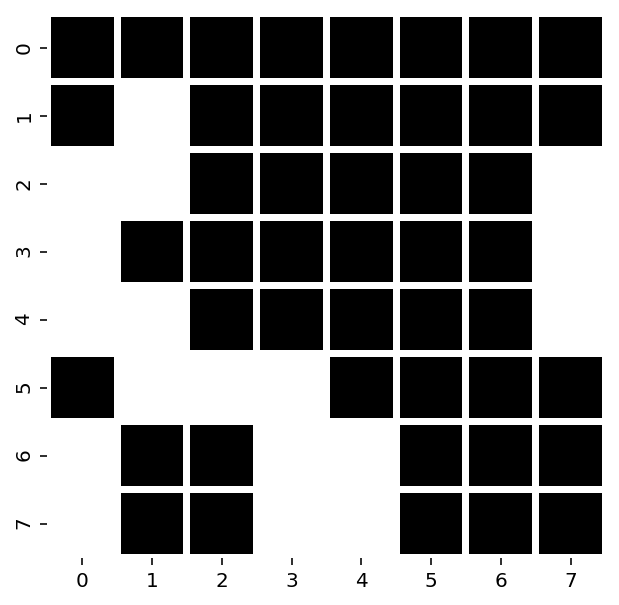

<IPython.core.display.Javascript object>

In [ ]:
maze = create_maze(8, k=5, t=10)
plot_maze(maze, plot=True, height=5, width=5)

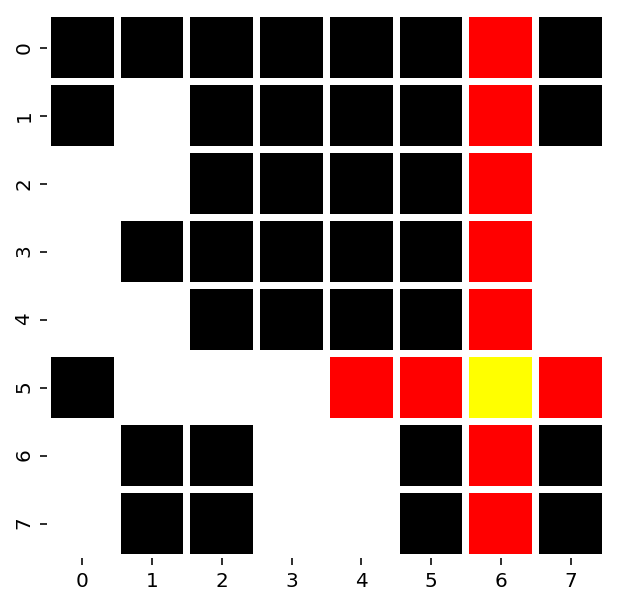

<IPython.core.display.Javascript object>

In [ ]:
x, y = random_move(maze)
available = available_moves(x, y, maze)
plot_available(x, y, maze, available, plot=True, height=5, width=5)